In [3]:
!pip install tf2crf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install -U 'scikit-learn<0.24'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from itertools import chain
import numpy as np

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from nltk.tokenize import word_tokenize
import numpy as np

import keras 
from tf2crf import CRF 
from tf2crf import ModelWithCRFLoss

from keras.models import Sequential,Model
from keras.layers import LSTM,Bidirectional,Dense,Input,Embedding,TimeDistributed
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [6]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [7]:
from google.colab import drive,files
drive.mount("/content/drive")
dataM='/content/drive/My Drive/Colab Notebooks/MODELS/'
filepath = dataM+'BiLSTM_CRF.ml'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!cp -rf drive/MyDrive/job_20k.json /content/

In [9]:
import pandas as pd
import json
path_to_json = 'job_20k.json'
df  = pd.read_json(path_to_json,lines=True)
df.head().T

,0,1,2,3,4
clean_descrition,A technology services client of ours is lookin...,Job Title :Java Sr developerLocation: RemoteLo...,Mandatory Skills: Strong in Oracle database 19...,"Associate Scientist Thousand Oaks, CADescripti...","Growing fintech company looking for Mid Level,..."
organization_list,"[Swift, Strategic, Solutions, Inc]","[AQUA, Information, Systems,, Inc.]","[Softnet, Consulting, Inc]","[Apex, Systems]",[Jobot]
skill_list,"[NoSQL, Teradata, Netezza, Cosmos, DB, JSON, A...","[Java, JEE, J2EE]","[Oracle, database, 19c, Advanced, PL/SQL, prog...","[Biochemistry, Biology, Analytical, Systems]","[Developer, JavaScript, SQL, ASP, HTML, Archit..."
job_title_list,"[Bigdata, Engineer]","[Java, developer]","[Oracle, PL/SQL, Lead, Architect]","[Associate, Scientist]","[Software, Engineer]"


In [10]:
df['clean_descrition'] = df['clean_descrition'].str.replace(r'[^\w\s]+', ' ')
df['clean_descrition'] = df['clean_descrition'].apply(lambda x: ' '.join(x.split()[:128]))
df['clean_descrition'][1]

<ipython-input-10-42c4f31900d0>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_descrition'] = df['clean_descrition'].str.replace(r'[^\w\s]+', ' ')


'Job Title Java Sr developerLocation RemoteLong TermSkills java jeShould have good understanding on the change management role and had depth knowledge on the change advisory board process CAB Good knowledge on the incident management Problem management Change Management Should have involved in the 3L level of activities i e root cause analysis environment analysis understanding the application architecture infrastructure architecture The resource should have very good understanding on the SDLC process Very good knowledge on the Java J2EE and have hands on experience in understanding the architecture of heterogeneous application Good communication skills and team handling abilities Should have worked on the onshore offshore model Should be flexible and having good attitude'

In [11]:
jobs = list(df.clean_descrition)
def convert_to_list_then_dict(df_column= None, key_value=str):
    value_list = list(df_column)
    _ = list(set([item for value_list in value_list for item in value_list]))
    return dict.fromkeys(_, key_value)

org = convert_to_list_then_dict(df_column=df.organization_list, key_value='C')
skill = convert_to_list_then_dict(df_column=df.skill_list, key_value='S')
job = convert_to_list_then_dict(df_column=df.job_title_list, key_value='J')    

In [12]:
XTr= jobs[:1500]
XVal= jobs[1500:2000]
org_b = org
skills_b = skill
jobs_b = job

In [13]:
def make(X,org_b,skills_b,jobs_b):
  big=[]
  for sentence in X:
    token=word_tokenize(sentence)
    small=[]
    token_t=nltk.pos_tag(token)
    for f,s in token_t:
      tag='O'
      if f.lower() in org_b:
        tag=org_b[f.lower()]
      if f.lower() in skills_b:
        tag=skills_b[f.lower()]
      if f.lower() in jobs_b:
        tag=jobs_b[f.lower()]
      small.append((f,s,tag))
    big.append(small)
  return big
XTr_=make(XTr,org_b,skills_b,jobs_b)
XVal_=make(XVal,org_b,skills_b,jobs_b)

In [14]:
msgLen=128

def fixMsg(X):
  global msgLen
  Xc=[]
  for i in range(len(X)):
    if len(X[i])<msgLen:
      Xc.append(X[i].copy())
      while len(Xc[-1])<msgLen:
        Xc[-1].append(('UNK','UNK','UNK'))
    elif len(X[i])>msgLen:
      Xc.append(X[i].copy())
      temp=Xc[-1].copy()
      del Xc[-1]
      lb=0;chunk=msgLen
      while lb<len(temp):
        split=[]
        for j in range(lb,lb+chunk):
          if j<len(temp):
            split.append(temp[j])
          else:
            split.append(('UNK','UNK','UNK'))
        Xc.append(split)
        assert(len(split)==msgLen)
        lb+=chunk
  return Xc

XTr_t=fixMsg(XTr_)
XVal_t=fixMsg(XVal_)

In [15]:
for x in XTr_t:
  assert(len(x)==msgLen)
print(XTr_t[0])
for x in XVal_t:
  assert(len(x)==msgLen)
print(XVal_t[0])

[('Job', 'NNP', 'J'), ('Title', 'NNP', 'O'), ('Java', 'NNP', 'J'), ('Sr', 'NNP', 'J'), ('developerLocation', 'NN', 'O'), ('RemoteLong', 'NNP', 'O'), ('TermSkills', 'NNP', 'O'), ('java', 'NN', 'J'), ('jeShould', 'NN', 'O'), ('have', 'VBP', 'J'), ('good', 'JJ', 'J'), ('understanding', 'NN', 'J'), ('on', 'IN', 'J'), ('the', 'DT', 'J'), ('change', 'NN', 'S'), ('management', 'NN', 'J'), ('role', 'NN', 'J'), ('and', 'CC', 'J'), ('had', 'VBD', 'O'), ('depth', 'VBN', 'J'), ('knowledge', 'NN', 'J'), ('on', 'IN', 'J'), ('the', 'DT', 'J'), ('change', 'NN', 'S'), ('advisory', 'JJ', 'O'), ('board', 'NN', 'S'), ('process', 'NN', 'J'), ('CAB', 'NNP', 'O'), ('Good', 'NNP', 'J'), ('knowledge', 'NN', 'J'), ('on', 'IN', 'J'), ('the', 'DT', 'J'), ('incident', 'JJ', 'S'), ('management', 'NN', 'J'), ('Problem', 'NNP', 'S'), ('management', 'NN', 'J'), ('Change', 'NNP', 'S'), ('Management', 'NNP', 'J'), ('Should', 'NNP', 'S'), ('have', 'VBP', 'J'), ('involved', 'VBN', 'S'), ('in', 'IN', 'J'), ('the', 'DT', 'J

In [16]:
dict_={}
dict_1={}
token=1;token1=0
for x in XTr_t:
  for a,b,c in x:
    if a not in dict_:
      dict_[a]=token
      token=token+1
    if c not in dict_1:
      if c=='K':
        print(a,b,c)
      dict_1[c]=token1
      token1=token1+1
for x in XVal_t:
  for a,b,c in x:
    if a not in dict_:
      dict_[a]=token
      token=token+1
    if c not in dict_1:
      dict_1[c]=token1
      token1=token1+1
print('No of tokens words[{}] labels[{}]'.format(token,token1))

No of tokens words[6014] labels[5]


In [17]:
XTr_fin=np.array([[dict_[element[0]] for element in sentence] for sentence in XTr_t])
XVal_fin=np.array([[dict_[element[0]] for element in sentence] for sentence in XVal_t])

yTr=np.array([[dict_1[element[2]] for element in sentence] for sentence in XTr_t])
yVal=np.array([[dict_1[element[2]] for element in sentence] for sentence in XVal_t])

In [18]:
embedding_dim = 100
input=Input(shape=(msgLen,))
mo=Embedding(input_dim=token,output_dim=embedding_dim)(input)
frwd=LSTM(64,return_sequences=True)
back=LSTM(64,return_sequences=True,go_backwards=True)
mo=Bidirectional(frwd,backward_layer=back)(mo)
mo=TimeDistributed(Dense(32,activation='relu'))(mo)
output=CRF(units=token1)(mo)
mo=Model(input,output)
mo.summary()

model=ModelWithCRFLoss(mo, sparse_target=True)
model.compile(optimizer ='rmsprop')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 100)          601400    
                                                                 
 bidirectional (Bidirectiona  (None, 128, 128)         84480     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 128, 32)          4128      
 ibuted)                                                         
                                                                 
 crf (CRF)                   ((None, 128),             190       
                              (None, 128, 5),                    
                              (None,),                       

In [19]:
es = EarlyStopping(monitor = "val_loss_val", mode = "min", verbose = True, restore_best_weights=True, patience = 1)
cp = ModelCheckpoint(filepath,monitor="val_loss_val",mode = "min",verbose=True,save_best_only=True)

history = model.fit(XTr_fin,yTr,validation_data=[XVal_fin,yVal],epochs=10,batch_size=100,callbacks=[cp,es])

Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 206.2295 - accuracy: 0.1424
Epoch 1: val_loss_val improved from inf to 192.72813, saving model to /content/drive/My Drive/Colab Notebooks/MODELS/BiLSTM_CRF.ml


3/3 [==============================] - 41s 16s/step - loss: 206.2295 - accuracy: 0.1424 - val_loss_val: 192.7281 - val_val_accuracy: 0.3096
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 176.6676 - accuracy: 0.4321
Epoch 2: val_loss_val improved from 192.72813 to 142.97426, saving model to /content/drive/My Drive/Colab Notebooks/MODELS/BiLSTM_CRF.ml


3/3 [==============================] - 29s 14s/step - loss: 176.6676 - accuracy: 0.4321 - val_loss_val: 142.9743 - val_val_accuracy: 0.6169
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 126.6244 - accuracy: 0.6746
Epoch 3: val_loss_val improved from 142.97426 to 124.51594, saving model to /content/drive/My Drive/Colab Notebooks/MODELS/BiLSTM_CRF.ml


3/3 [==============================] - 30s 15s/step - loss: 126.6244 - accuracy: 0.6746 - val_loss_val: 124.5159 - val_val_accuracy: 0.6459
Epoch 4/10
3/3 [==============================] - ETA: 0s - loss: 110.3599 - accuracy: 0.6945
Epoch 4: val_loss_val improved from 124.51594 to 108.89038, saving model to /content/drive/My Drive/Colab Notebooks/MODELS/BiLSTM_CRF.ml


3/3 [==============================] - 31s 15s/step - loss: 110.3599 - accuracy: 0.6945 - val_loss_val: 108.8904 - val_val_accuracy: 0.6981
Epoch 5/10
3/3 [==============================] - ETA: 0s - loss: 100.3731 - accuracy: 0.7244
Epoch 5: val_loss_val improved from 108.89038 to 103.63460, saving model to /content/drive/My Drive/Colab Notebooks/MODELS/BiLSTM_CRF.ml


3/3 [==============================] - 28s 14s/step - loss: 100.3731 - accuracy: 0.7244 - val_loss_val: 103.6346 - val_val_accuracy: 0.6997
Epoch 6/10
3/3 [==============================] - ETA: 0s - loss: 96.4014 - accuracy: 0.7214
Epoch 6: val_loss_val improved from 103.63460 to 100.35658, saving model to /content/drive/My Drive/Colab Notebooks/MODELS/BiLSTM_CRF.ml


3/3 [==============================] - 29s 14s/step - loss: 96.4014 - accuracy: 0.7214 - val_loss_val: 100.3566 - val_val_accuracy: 0.7025
Epoch 7/10
3/3 [==============================] - ETA: 0s - loss: 92.2213 - accuracy: 0.7255
Epoch 7: val_loss_val improved from 100.35658 to 95.93298, saving model to /content/drive/My Drive/Colab Notebooks/MODELS/BiLSTM_CRF.ml


3/3 [==============================] - 29s 14s/step - loss: 92.2213 - accuracy: 0.7255 - val_loss_val: 95.9330 - val_val_accuracy: 0.7032
Epoch 8/10
3/3 [==============================] - ETA: 0s - loss: 88.4202 - accuracy: 0.7279
Epoch 8: val_loss_val improved from 95.93298 to 93.14385, saving model to /content/drive/My Drive/Colab Notebooks/MODELS/BiLSTM_CRF.ml


3/3 [==============================] - 29s 14s/step - loss: 88.4202 - accuracy: 0.7279 - val_loss_val: 93.1439 - val_val_accuracy: 0.7056
Epoch 9/10
3/3 [==============================] - ETA: 0s - loss: 86.3605 - accuracy: 0.7253
Epoch 9: val_loss_val did not improve from 93.14385
Restoring model weights from the end of the best epoch: 8.
3/3 [==============================] - 2s 562ms/step - loss: 86.3605 - accuracy: 0.7253 - val_loss_val: 95.9767 - val_val_accuracy: 0.6899
Epoch 9: early stopping


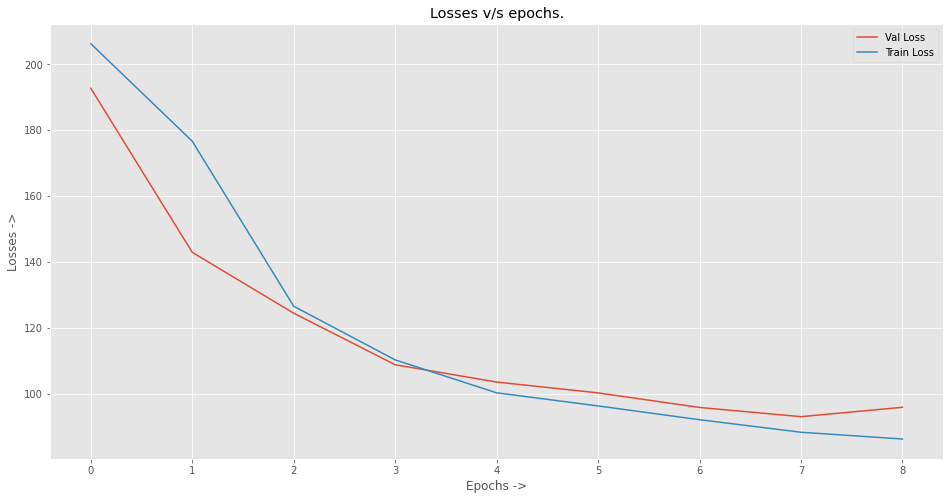

In [20]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16,8)
plt.plot(history.history['val_loss_val'])
plt.plot(history.history['loss'])
plt.xlabel('Epochs ->')
plt.ylabel('Losses ->')
plt.title('Losses v/s epochs.')
plt.legend(['Val Loss','Train Loss'])
plt.show()

In [21]:
dict_1R={}
for k,v in dict_1.items():
  dict_1R[v]=k

In [22]:
labels_=model.predict(XVal_fin)
i=0 # i-th example from val dataset.
cnt=0
print()
for x in XVal_[0]:
  print('{} {}'.format(x[0],dict_1R[labels_[i][cnt]]))
  cnt+=1

3/3 [==============================] - 2s 60ms/step

Title J
ServiceNow J
Developer J
Duration J
12 J
24 J
month J
contract J
or J
CTH J
Location J
San J
Antonio J
TX J
Plano J
TX J
or J
RemoteJob J
description J
We J
are J
currently J
seeking J
a J
talented J
ServiceNow J
Developer J
Mid J
Level J
for J
our J
Plano J
TX J
or J
San J
Antonio J
TX J
facility UNK
This UNK
person UNK
may UNK
also UNK
work UNK
remotely UNK
in UNK
a UNK
100 UNK
Remote UNK
Work UNK
Environment UNK
Our UNK
client UNK
values UNK
a UNK
culture UNK
that UNK
is UNK
highly UNK
collaborative UNK
and UNK
we UNK
have UNK
found UNK
that UNK
a UNK
hybrid UNK
work UNK
type UNK
helps UNK
employees UNK
gain UNK
the UNK
best UNK
of UNK
both UNK
worlds UNK
collaborating UNK
in UNK
person UNK
in UNK
the UNK
office UNK
and UNK
working UNK
from UNK
home UNK
when UNK
needed UNK
to UNK
achieve UNK
focused UNK
deliverables UNK
The UNK
actual UNK
days UNK
onsite UNK
are UNK
determined UNK
between UNK
each UNK
employee UNK
and UNK


In [23]:
dict_1

{'J': 0, 'O': 1, 'S': 2, 'UNK': 3, 'C': 4}

In [24]:
!pip install sklearn-crfsuite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

def labelIt(yVal):
  yVal_lis=[]
  for y1 in yVal:
    temp=[]
    for y2 in y1:
      temp.append(dict_1R[y2])
    yVal_lis.append(temp)
  return yVal_lis 

yVal_=labelIt(yVal)
yPred_=labelIt(labels_)
labls=['C','J','S','O','UNK']
metrics.flat_f1_score(yVal_,yPred_,average='weighted',labels=labls)

0.6026296386145195

In [26]:
print(metrics.flat_classification_report(yVal_,yPred_,labels=labls,digits=3))

              precision    recall  f1-score   support

           C      0.000     0.000     0.000        10
           J      0.545     0.992     0.704      4119
           S      0.000     0.000     0.000      1889
           O      0.000     0.000     0.000      1563
         UNK      0.980     0.998     0.989      4323

    accuracy                          0.706     11904
   macro avg      0.305     0.398     0.339     11904
weighted avg      0.545     0.706     0.603     11904



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['C', 'J', 'S', 'O', 'UNK'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
